# **Capgemini Datachallenge 2025**


- one model for the 2 countries


In [ ]:
%load_ext autoreload
%autoreload 2
# Main imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from codecarbon import EmissionsTracker
import time

from src2.utils.pipeline import (
    LagFeatureGeneratorNoMultiIndex,
    create_non_linear_features,
    create_final_preprocessor,
    create_datetime_features_multiindex,
)


In [ ]:
PROJECT_ROOT = Path().cwd().parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

INPUT_DIR = PROJECT_ROOT / "data/input"
EVAL_DIR = PROJECT_ROOT / "data/evaluation"


datasets = {"train": INPUT_DIR, "eval": EVAL_DIR}

data = {}
for set, dir in datasets.items():
    data[set] = pd.read_csv(dir / f"dataset_baseline.csv")

FEAT_TO_DROP = [
    "is_winter",
    "is_spring",
    "is_summer",
    "is_autumn",
    "is_jan",
    "is_feb",
    "is_mar",
    "is_apr",
    "is_may",
    "is_jun",
    "is_jul",
    "is_aug",
    "is_sep",
    "is_oct",
    "is_nov",
    "is_dec",
]

# --- Config ---
TARGETS = [
    "water_flow_week1",
    "water_flow_week2",
    "water_flow_week3",
    # "water_flow_week4",
]
TO_DROP = TARGETS + ["station_code", "ObsDate"]

# X_cols = DYNAMIC_COLUMNS + STATIC_COLUMNS

TIME_VALIDATION = "2000-01-01 00:00:00"


NUMBER_OF_WEEK = 3
# TIME_VALIDATION = "2000-01-01 00:00:00"
# TOTAL_STATIONS = 39

In [3]:
# Add calendar features (cylic month + seasons)
def calendar_features(dates: pd.Series) -> pd.DataFrame:
    m = dates.dt.month
    days = dates.dt.day
    # cyclical month
    cal = pd.DataFrame(
        {
            "month_sin": np.sin(2 * np.pi * (m / 12.0)),
            "month_cos": np.cos(2 * np.pi * (m / 12.0)),
            "sin_dayofyear": np.sin(2 * np.pi * days / 365.25),
            "cos_dayofyear": np.cos(2 * np.pi * days / 365.25),
        },
        index=dates.index,
    )
    return cal


def display_columns_square(df):
    """
    Displays the column names of a pandas DataFrame in a square-like table format.

    Args:
        df (pd.DataFrame): The DataFrame to process.
    """
    column_names = df.columns.tolist()
    column_names = sorted(column_names)
    num_cols = len(column_names)

    if num_cols == 0:
        print("The DataFrame has no columns.")
        return

    # 1. Calculate the dimensions for the square table
    # The number of rows and columns is the ceiling of the square root of num_cols
    import math

    table_dimension = math.ceil(np.sqrt(num_cols))

    # 2. Reshape the column names into the table structure
    # Determine the number of empty cells needed to fill the grid
    total_cells = table_dimension * table_dimension
    padding = total_cells - num_cols

    # Add empty strings for padding (if needed)
    padded_names = column_names + [""] * padding

    # Convert the list into a numpy array and reshape it into the square matrix
    # The order is filled row by row
    square_array = np.array(padded_names).reshape(table_dimension, table_dimension)

    # 3. Convert the numpy array back into a pandas DataFrame for a clean table output
    table_df = pd.DataFrame(square_array)

    print("✨ Column Names in Square Table Format:")
    # Display the DataFrame without index or header for a cleaner look
    print(table_df.to_string(index=False, header=False))


# Fix Latitude and Longitude
dataset_baseline = {}
for set, dir in datasets.items():
    path_data_baseline_france = dir / f"preprocessed_france.csv"
    dataset_baseline_france = pd.read_csv(path_data_baseline_france)

    dataset_baseline_france = dataset_baseline_france.iloc[:, 1:]
    dataset_baseline_france = dataset_baseline_france.drop(columns=["index"])

    dataset_baseline_france = dataset_baseline_france.set_index("ObsDate")

    path_data_baseline = dir / f"preprocessed_brazil.csv"
    dataset_baseline_brazil = pd.read_csv(path_data_baseline)

    # remove the first column
    dataset_baseline_brazil = dataset_baseline_brazil.iloc[:, 1:]
    dataset_baseline_brazil = dataset_baseline_brazil.drop(columns=["index"])

    dataset_baseline_brazil = dataset_baseline_brazil.set_index("ObsDate")

    dataset_baseline_france["north_hemisphere"] = 1
    dataset_baseline_brazil["north_hemisphere"] = 0

    dataset_baseline[set] = pd.concat(
        [dataset_baseline_france, dataset_baseline_brazil], axis=0
    )

    data[set]["latitude"] = dataset_baseline[set]["latitude"].values
    data[set]["longitude"] = dataset_baseline[set]["longitude"].values

    # Add additional calendar features
    data_calendar_features = calendar_features(pd.to_datetime(data[set]["ObsDate"]))
    data[set] = pd.concat([data[set], data_calendar_features], axis=1)


dataset_train = data["train"].copy()
dataset_test = data["eval"].copy()

# drop features
dataset_train = dataset_train.drop(columns=FEAT_TO_DROP)
dataset_test = dataset_test.drop(columns=FEAT_TO_DROP)

display_columns_square(dataset_train)

✨ Column Names in Square Table Format:
                            ObsDate                          altitude       bdod_0-5cm_mean_index__region         bdod_0-5cm_mean_index__sector  bdod_0-5cm_mean_index__sub_sector           bdod_0-5cm_mean_index__zone    bdod_100-200cm_mean_index__region     bdod_100-200cm_mean_index__sector bdod_100-200cm_mean_index__sub_sector     bdod_100-200cm_mean_index__zone      bdod_15-30cm_mean_index__region      bdod_15-30cm_mean_index__sector bdod_15-30cm_mean_index__sub_sector
      bdod_15-30cm_mean_index__zone   bdod_30-60cm_mean_index__region     bdod_30-60cm_mean_index__sector   bdod_30-60cm_mean_index__sub_sector      bdod_30-60cm_mean_index__zone        bdod_5-15cm_mean_index__region       bdod_5-15cm_mean_index__sector    bdod_5-15cm_mean_index__sub_sector          bdod_5-15cm_mean_index__zone    bdod_60-100cm_mean_index__region     bdod_60-100cm_mean_index__sector bdod_60-100cm_mean_index__sub_sector      bdod_60-100cm_mean_index__zone
         

## LGBM Model


In [ ]:
# # --- Split train/validation by date ---
# def split_time(df, cutoff=TIME_VALIDATION):
#     train = df[df["ObsDate"] < cutoff].copy()
#     valid = df[df["ObsDate"] >= cutoff].copy()
#     return train, valid
# --- Split time by percentage
def split_time(df,cutoff_perc=0.80):
    train=df[]

def log_transform(y):
    return np.log1p(y)  # log(1 + y) to handle zeros


def inverse_log_transform(y):
    return np.expm1(y)  # exp(y) - 1 to reverse log(1 + y)


# import transformedtargetregressor
from sklearn.compose import TransformedTargetRegressor


# --- Quantile model builder ---
common_params = dict(
    n_estimators=1000,  # Set high, will be controlled by early stopping
    learning_rate=0.02,
    # --- Tree Complexity & Regularization ---
    num_leaves=20,  # Decrease to regularize
    max_depth=5,  # Add to control depth
    min_data_in_leaf=50,  # Increase to regularize
    # --- Penalties (L1 & L2) ---
    reg_lambda=5.0,  # Increase to regularize
    reg_alpha=0.1,  # Add L1 penalty
    # --- Subsampling (Stochasticity) ---
    feature_fraction=0.8,  # Decrease to regularize
    bagging_fraction=0.8,  # Decrease to regularize
    # bagging_freq=1,
    # --- Other ---
    n_jobs=-1,
    verbosity=-1,
)


def build_quantile_lgbm(alpha, params=None):
    params = {} if params is None else params.copy()
    params.update({"objective": "quantile", "alpha": alpha})
    return LGBMRegressor(**params)


def build_regression_lgbm(params=None):
    params = {} if params is None else params.copy()
    return LGBMRegressor(**params)


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Define the early stopping callback
# import lgb
import lightgbm as lgb

early_stopping_callback = lgb.early_stopping(
    stopping_rounds=50,  # Stops if val score doesn't improve for 50 rounds
    verbose=True,
)


def fit_model(model, Xtr, ytr, Xva, yva, tracker_name):
    tracker = EmissionsTracker(
        project_name=tracker_name,
        measure_power_secs=1,
        tracking_mode="process",
        log_level="WARNING",
        save_to_file=False,
    )
    tracker.start()
    start_time = time.time()

    model.fit(
        Xtr,
        ytr,
        eval_set=[(Xva, yva)],
        eval_metric="l2",
        callbacks=[early_stopping_callback],
    )
    emissions_kg = tracker.stop()

    duration = time.time() - start_time

    energy_kwh = tracker.final_emissions_data.energy_consumed

    preds = model.predict(Xva)
    carbon_results = {
        "duration_seconds": duration,
        "emissions_kg": emissions_kg,
        "cpu_energy_kwh": energy_kwh,
    }
    return preds, model, carbon_results


# --- Training function ---
def process_df(df):
    df = df.sort_values(by=["ObsDate", "station_code"]).reset_index(drop=True)

    # ✅ Fix: correct lag column name
    lagger = LagFeatureGeneratorNoMultiIndex(
        lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        cols_to_lag=[
            "water_flow_lag_1w",  # fixed name
            "temperatures",
            "soil_moisture",
            "precipitations",
            "evaporation",
        ],
    )
    df = lagger.transform(df, group_col="station_code", datetime_col="ObsDate")
    df = create_non_linear_features(df)

    # rolling features
    for col in ["temperatures", "soil_moisture", "precipitations", "evaporation"]:
        for w in [3, 5, 7]:
            grp = df.groupby("station_code")[col]
            df[f"{col}_roll_mean_{w}w"] = grp.transform(
                lambda x: x.rolling(w, 1).mean()
            )
            df[f"{col}_roll_std_{w}w"] = grp.transform(
                lambda x: x.rolling(w, 1).std()
            ).fillna(0)

    return df


def evaluate_results(results, preds_key="regression"):
    out = []
    for target, res in results.items():
        y_true = res["true"]
        y_pred_med = res["preds"][preds_key]
        mse = mean_squared_error(y_true, y_pred_med)
        mae = mean_absolute_error(y_true, y_pred_med)
        out.append(
            {"target": target, f"MSE ({preds_key})": mse, f"MAE ({preds_key})": mae}
        )
    return pd.DataFrame(out)


def carbon_analysis(carbon_results, MODEL_DIR=None):
    # Display carbon footprint results
    carbon_df = pd.DataFrame(carbon_results)
    carbon_summary = (
        carbon_df.groupby("model")
        .agg(
            {
                "duration_seconds": ["mean", "sum"],
                "emissions_kg": ["mean", "sum"],
                "cpu_energy_kwh": ["mean", "sum"],
            }
        )
        .round(6)
    )

    print("\n=== COMPUTATIONAL COST SUMMARY ===")
    print(carbon_summary)

    # Save for paper
    # carbon_df.to_csv(f"{MODEL_DIR}carbon_footprint.csv", index=False)

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))

    # Training time by model
    carbon_df.groupby("model")["duration_seconds"].sum().plot(kind="bar", ax=axes[0])
    axes[0].set_title("Total Training Time (seconds)")
    axes[0].set_ylabel("Time (s)")

    # Energy consumption
    carbon_df.groupby("model")["cpu_energy_kwh"].sum().plot(kind="bar", ax=axes[1])
    axes[1].set_title("Total Energy Consumption")
    axes[1].set_ylabel("kWh")

    plt.tight_layout()
    # plt.savefig(f"{MODEL_DIR}computational_cost.png", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit


def get_lgbm_param_dist():
    """
    Defines the hyperparameter search space for RandomizedSearchCV.
    Parameters are prefixed with 'regressor__' because we are tuning
    a model inside a TransformedTargetRegressor.
    """
    return {
        "regressor__n_estimators": randint(600, 1000),
        "regressor__learning_rate": uniform(0.01, 0.05),
        "regressor__max_depth": randint(3, 6),
        "regressor__num_leaves": randint(20, 40),
        "regressor__min_data_in_leaf": randint(30, 100),
        "regressor__feature_fraction": uniform(
            0.6, 0.3
        ),  # Base 0.6, range 0.3 -> [0.6, 0.9]
        "regressor__bagging_fraction": uniform(0.6, 0.3),
        "regressor__reg_lambda": uniform(1.0, 10.0),
        "regressor__reg_alpha": uniform(0.0, 10.0),
    }


from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit


def find_best_params(X_train, y_train, n_iter=40, cv_splits=5):
    print("  Running RandomizedSearchCV (no fit-time callbacks)...")

    # Base model used inside TransformedTargetRegressor for the search
    base_model = LGBMRegressor(
        # n_estimators=600,  # enough trees so models can learn during CV
        n_jobs=-1,
        verbosity=-1,
    )

    estimator = TransformedTargetRegressor(
        regressor=base_model,
        func=log_transform,
        inverse_func=inverse_log_transform,
    )

    param_dist = get_lgbm_param_dist()  # uses "regressor__<param>" keys — OK
    tscv = TimeSeriesSplit(n_splits=cv_splits)

    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        cv=tscv,
        verbose=1,
        random_state=42,
        refit=True,
        error_score="raise",  # raise so failures are visible while debugging
    )

    # IMPORTANT: do NOT attempt to pass regressor__callbacks or regressor__eval_metric here.
    # We run the search WITHOUT fit-time early stopping for CV stability.
    random_search.fit(X_train, y_train)

    print(f"  Best CV RMSE: {-random_search.best_score_:.4f}")

    # Extract best params (keys like 'regressor__num_leaves' -> 'num_leaves')
    best_params_cleaned = {
        key.replace("regressor__", ""): val
        for key, val in random_search.best_params_.items()
    }

    print(f"  Best params (cleaned): {best_params_cleaned}")
    return best_params_cleaned


def train_single_target_models(
    Xtr,
    ytr,
    Xva,
    yva,
    best_params,
    target_name,
    quantiles=[0.1, 0.5, 0.9],
    if_regression=True,
    if_quantiles=True,
):
    models = {}
    preds = {}
    carbon_results_all = {}

    if if_quantiles:
        for q in quantiles:
            # Build quantile model using best_params
            model_q = build_quantile_lgbm(alpha=q, params=best_params)

            model_q_wrapped = TransformedTargetRegressor(
                regressor=model_q,
                func=log_transform,
                inverse_func=inverse_log_transform,
            )

            # When fitting the wrapped estimator, pass eval_set and callbacks **without** prefix
            preds_model, model, carbon_results = fit_model(
                model_q_wrapped, Xtr, ytr, Xva, yva, tracker_name=f"{target_name}_q_{q}"
            )

            preds[f"LGBM_quantile_{q}"] = preds_model
            models[f"LGBM_quantile_{q}"] = model
            carbon_results_all[f"LGBM_quantile_{q}"] = carbon_results

    if if_regression:
        model_reg = build_regression_lgbm(params=best_params)
        model_reg_wrapped = TransformedTargetRegressor(
            regressor=model_reg,
            func=log_transform,
            inverse_func=inverse_log_transform,
        )

        preds_model, model, carbon_results = fit_model(
            model_reg_wrapped, Xtr, ytr, Xva, yva, tracker_name=f"{target_name}_reg"
        )

        preds["LGBM_regression"] = preds_model
        models["LGBM_regression"] = model
        carbon_results_all["LGBM_regression"] = carbon_results

    return {"models": models, "preds": preds, "carbon_results": carbon_results_all}


def train_all_targets(Xtr, ytr_all, Xva, yva_all, run_search=True, n_iter=20):
    """
    Loops through all targets, finds best params for each,
    and trains all necessary models.
    """
    results = {}
    all_best_params = {}  # Store params for later inspection

    for i, target in enumerate(TARGETS):
        print(f"\n=== Training models for {target} ===")
        ytr, yva = ytr_all[target], yva_all[target]

        best_params = {}
        if run_search:
            # 1. Find best params for this specific target
            best_params = find_best_params(Xtr, ytr, n_iter=n_iter, cv_splits=3)
            all_best_params[target] = best_params

        # 2. Train all models (quantile + reg) for this target
        target_results = train_single_target_models(
            Xtr,
            ytr,
            Xva,
            yva,
            best_params=best_params,
            target_name=target,
            if_regression=False,
            if_quantiles=True,
        )

        # 3. Store results
        results[target] = {
            **target_results,  # Unpack models, preds, carbon_results
            "true": yva.values,
        }

    print("\n=== Training complete ===")
    if run_search:
        print("Best parameters found:")
        for target, params in all_best_params.items():
            print(f"  {target}: {params}")

    return results, all_best_params


def run_training_pipeline(df, run_search=True, n_iter=20):
    """
    Main function to run the complete training and validation pipeline.

    Args:
        df: The initial dataframe.
        run_search: (bool) Whether to run RandomizedSearchCV.
        n_iter: (int) Number of iterations for RandomizedSearchCV.
    """
    # 1. Process data
    print("Processing data...")
    df = process_df(df)

    # 2. Split data
    train, valid = split_time(df)
    Xtr, Xva = train.drop(columns=TO_DROP), valid.drop(columns=TO_DROP)
    ytr_all, yva_all = train[TARGETS], valid[TARGETS]

    # 3. Train all models
    results, all_best_params = train_all_targets(
        Xtr, ytr_all, Xva, yva_all, run_search=run_search, n_iter=n_iter
    )

    return results, valid, all_best_params


def run_test_pipeline_extended(all_models, dataset_test):
    # process
    dataset_test = process_df(dataset_test)
    X_cols_pred = dataset_test.columns.difference(TO_DROP, sort=False)

    # Dictionary to hold predictions from all models
    all_y_preds = {}

    # Dictionary for the original output (quantile_0.5 only)
    y_pred_test_q05 = {}

    X_test = dataset_test[X_cols_pred]

    # DataFrame to build the extended output
    full_pred = dataset_test[["station_code", "ObsDate"]].copy()

    for i in range(NUMBER_OF_WEEK):
        week_key = f"week_{i+1}"
        week_num = i + 1
        model_set = all_models[week_key]

        # Add the original target column (if present in TO_DROP it will be excluded from X_test)
        target_col = f"water_flow_week{week_num}"
        if target_col in dataset_test.columns:
            full_pred[target_col] = dataset_test[target_col].values

        # Iterate through all models for the current week
        for model_name, model in model_set.items():
            # Generate prediction
            y_pred = model.predict(X_test)

            # Create the required column name
            pred_col_name = f"water_flow_week{week_num}_{model_name}"

            # Store prediction in the extended dataframe
            full_pred[pred_col_name] = y_pred

            # Store the prediction for the original output (LGBM_quantile_0.5 only)
            if model_name == "LGBM_quantile_0.5":
                y_pred_test_q05[i] = y_pred

    # --- Original Output Construction ---
    # This section remains focused on the LGBM_quantile_0.5 predictions
    predictions = dataset_test[["station_code"]].copy()
    for i in range(NUMBER_OF_WEEK):
        predictions[f"week_{i}_pred"] = y_pred_test_q05[i]

    predictions["ObsDate"] = dataset_test["ObsDate"].values

    predictions["id"] = (
        predictions["station_code"].astype(str)
        + "_"
        + dataset_test["ObsDate"].astype(str)
    )
    predictions = predictions[
        ["id"] + [f"week_{i}_pred" for i in range(NUMBER_OF_WEEK)]
    ]
    predictions.reset_index(drop=True, inplace=True)

    first_cols = ["station_code", "ObsDate"]
    remaining_cols = [col for col in full_pred.columns if col not in first_cols]

    # Sort remaining columns by week and then by model type for clean output
    def sort_key(col):
        # Extracts week number and model type for sorting
        if "week" in col:
            parts = col.split("_")
            week_num_str = parts[1].replace("week", "")
            model_type = parts[-1] if "LGBM" in col else "A"  # 'A' to put targets first
            try:
                week_num = int(week_num_str)
            except ValueError:
                week_num = 99  # Put unparsed later
            return (week_num, model_type)
        return (0, "A")  # Put non-week related columns first

    remaining_cols.sort(key=sort_key)

    full_pred = full_pred[first_cols + remaining_cols]

    # dataset_test_w_preds is the requested extended dataframe
    return predictions, full_pred

In [6]:
# Train models for different q values
from src2.utils.pipeline import split_dataset_custom

train, spatio_temporal_test, temporal_test = split_dataset_custom(
    dataset_train, p=0.90, time="2003-01-01", seed=42
)

print("Dataset shapes:")
print(train.shape)
print(spatio_temporal_test.shape)
print(temporal_test.shape)

📊 Dataset split summary
  • Train stations: 35 | Test stations: 4
  • Train data shape: (23660, 148)
  • Spatio-temporal test shape: (212, 148)
  • Temporal test shape: (1855, 148)
Dataset shapes:
(23660, 148)
(212, 148)
(1855, 148)


Training


In [7]:
results, valid, all_best_params = run_training_pipeline(
    df=train, run_search=True, n_iter=25
)

Processing data...

=== Training models for water_flow_week1 ===
  Running RandomizedSearchCV (no fit-time callbacks)...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[codecarbon WARNING @ 01:38:32] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 01:38:32] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 01:38:32] We saw that you have a Apple M3 but we don't know it. Please contact us.


  Best CV RMSE: 81.4432
  Best params (cleaned): {'bagging_fraction': np.float64(0.6605157607006188), 'feature_fraction': np.float64(0.8687290787020558), 'learning_rate': np.float64(0.03376851115910559), 'max_depth': 3, 'min_data_in_leaf': 33, 'n_estimators': 821, 'num_leaves': 24, 'reg_alpha': np.float64(2.4929222914887497), 'reg_lambda': np.float64(5.103829230356297)}


[codecarbon WARNING @ 01:38:32] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 01:38:32] No CPU tracking mode found. Falling back on CPU constant mode.


Training until validation scores don't improve for 50 rounds


[codecarbon WARNING @ 01:38:34] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 01:38:34] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 01:38:34] We saw that you have a Apple M3 but we don't know it. Please contact us.


Did not meet early stopping. Best iteration is:
[821]	valid_0's l2: 60182.7	valid_0's quantile: 8.31101


[codecarbon WARNING @ 01:38:34] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 01:38:34] No CPU tracking mode found. Falling back on CPU constant mode.


Training until validation scores don't improve for 50 rounds


[codecarbon WARNING @ 01:38:37] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 01:38:37] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 01:38:37] We saw that you have a Apple M3 but we don't know it. Please contact us.


Early stopping, best iteration is:
[749]	valid_0's l2: 60136	valid_0's quantile: 41.4457


[codecarbon WARNING @ 01:38:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 01:38:37] No CPU tracking mode found. Falling back on CPU constant mode.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 60196	valid_0's quantile: 73.5752

=== Training models for water_flow_week2 ===
  Running RandomizedSearchCV (no fit-time callbacks)...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[codecarbon WARNING @ 01:40:07] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 01:40:07] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 01:40:07] We saw that you have a Apple M3 but we don't know it. Please contact us.


  Best CV RMSE: 92.3048
  Best params (cleaned): {'bagging_fraction': np.float64(0.8284858845986153), 'feature_fraction': np.float64(0.6712912631977199), 'learning_rate': np.float64(0.046410817430592985), 'max_depth': 3, 'min_data_in_leaf': 99, 'n_estimators': 994, 'num_leaves': 35, 'reg_alpha': np.float64(7.983451249845511), 'reg_lambda': np.float64(2.5071754396542945)}


[codecarbon WARNING @ 01:40:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 01:40:07] No CPU tracking mode found. Falling back on CPU constant mode.


Training until validation scores don't improve for 50 rounds


[codecarbon WARNING @ 01:40:09] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 01:40:09] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 01:40:09] We saw that you have a Apple M3 but we don't know it. Please contact us.


Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 61081.3	valid_0's quantile: 8.35431


[codecarbon WARNING @ 01:40:10] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 01:40:10] No CPU tracking mode found. Falling back on CPU constant mode.


Training until validation scores don't improve for 50 rounds


[codecarbon WARNING @ 01:40:12] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 01:40:12] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 01:40:12] We saw that you have a Apple M3 but we don't know it. Please contact us.


Early stopping, best iteration is:
[860]	valid_0's l2: 61025.1	valid_0's quantile: 41.6305


[codecarbon WARNING @ 01:40:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 01:40:12] No CPU tracking mode found. Falling back on CPU constant mode.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 61078.5	valid_0's quantile: 73.8873

=== Training models for water_flow_week3 ===
  Running RandomizedSearchCV (no fit-time callbacks)...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[codecarbon WARNING @ 01:41:49] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 01:41:49] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 01:41:49] We saw that you have a Apple M3 but we don't know it. Please contact us.


  Best CV RMSE: 118.1128
  Best params (cleaned): {'bagging_fraction': np.float64(0.7943070361624087), 'feature_fraction': np.float64(0.6001561130985947), 'learning_rate': np.float64(0.027628442816708454), 'max_depth': 5, 'min_data_in_leaf': 99, 'n_estimators': 736, 'num_leaves': 24, 'reg_alpha': np.float64(6.924360328902703), 'reg_lambda': np.float64(3.6941233379852148)}


[codecarbon WARNING @ 01:41:49] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 01:41:49] No CPU tracking mode found. Falling back on CPU constant mode.


Training until validation scores don't improve for 50 rounds


[codecarbon WARNING @ 01:41:52] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 01:41:52] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 01:41:52] We saw that you have a Apple M3 but we don't know it. Please contact us.


Did not meet early stopping. Best iteration is:
[736]	valid_0's l2: 63755.5	valid_0's quantile: 8.44604


[codecarbon WARNING @ 01:41:52] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 01:41:52] No CPU tracking mode found. Falling back on CPU constant mode.


Training until validation scores don't improve for 50 rounds


[codecarbon WARNING @ 01:41:55] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 01:41:55] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 01:41:55] We saw that you have a Apple M3 but we don't know it. Please contact us.


Did not meet early stopping. Best iteration is:
[736]	valid_0's l2: 63688	valid_0's quantile: 42.0657


[codecarbon WARNING @ 01:41:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 01:41:55] No CPU tracking mode found. Falling back on CPU constant mode.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 63728.6	valid_0's quantile: 74.6271

=== Training models for water_flow_week4 ===
  Running RandomizedSearchCV (no fit-time callbacks)...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[codecarbon WARNING @ 01:43:32] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 01:43:32] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 01:43:32] We saw that you have a Apple M3 but we don't know it. Please contact us.


  Best CV RMSE: 127.6749
  Best params (cleaned): {'bagging_fraction': np.float64(0.8266653415629146), 'feature_fraction': np.float64(0.6686394496474867), 'learning_rate': np.float64(0.01384899549143965), 'max_depth': 5, 'min_data_in_leaf': 57, 'n_estimators': 665, 'num_leaves': 29, 'reg_alpha': np.float64(8.08120379564417), 'reg_lambda': np.float64(7.334037565104235)}


[codecarbon WARNING @ 01:43:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 01:43:33] No CPU tracking mode found. Falling back on CPU constant mode.


Training until validation scores don't improve for 50 rounds


[codecarbon WARNING @ 01:43:35] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 01:43:35] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 01:43:35] We saw that you have a Apple M3 but we don't know it. Please contact us.


Did not meet early stopping. Best iteration is:
[665]	valid_0's l2: 69520.5	valid_0's quantile: 8.63134


[codecarbon WARNING @ 01:43:35] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 01:43:35] No CPU tracking mode found. Falling back on CPU constant mode.


Training until validation scores don't improve for 50 rounds


[codecarbon WARNING @ 01:43:38] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 01:43:38] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 01:43:38] We saw that you have a Apple M3 but we don't know it. Please contact us.


Did not meet early stopping. Best iteration is:
[664]	valid_0's l2: 69406.7	valid_0's quantile: 42.9525


[codecarbon WARNING @ 01:43:38] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 01:43:38] No CPU tracking mode found. Falling back on CPU constant mode.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 69438.2	valid_0's quantile: 76.1994

=== Training complete ===
Best parameters found:
  water_flow_week1: {'bagging_fraction': np.float64(0.6605157607006188), 'feature_fraction': np.float64(0.8687290787020558), 'learning_rate': np.float64(0.03376851115910559), 'max_depth': 3, 'min_data_in_leaf': 33, 'n_estimators': 821, 'num_leaves': 24, 'reg_alpha': np.float64(2.4929222914887497), 'reg_lambda': np.float64(5.103829230356297)}
  water_flow_week2: {'bagging_fraction': np.float64(0.8284858845986153), 'feature_fraction': np.float64(0.6712912631977199), 'learning_rate': np.float64(0.046410817430592985), 'max_depth': 3, 'min_data_in_leaf': 99, 'n_estimators': 994, 'num_leaves': 35, 'reg_alpha': np.float64(7.983451249845511), 'reg_lambda': np.float64(2.5071754396542945)}
  water_flow_week3: {'bagging_fraction': np.float64(0.7943070361624087), 'feature_fraction': np.float64(0.60015

In [8]:
import os
import pickle
from datetime import datetime


# --- Define a timestamped folder name ---
def save_models_directory(
    results,
    all_best_params=None,
    filename="trained_models_on_split.pkl",
    param_filename="best_params_on_split.pkl",
):
    run_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_dir = os.path.join("../models2", f"run_{run_timestamp}")

    # --- Create directory if it doesn’t exist ---
    os.makedirs(save_dir, exist_ok=True)

    # --- Build dictionary of all models ---
    all_models = {}
    for i in range(NUMBER_OF_WEEK):
        week = i + 1
        all_models[f"week_{week}"] = results[f"water_flow_week{week}"]["models"]

    # --- Define full save path ---

    file_path = os.path.join(save_dir, filename)

    # --- Save with pickle ---
    with open(file_path, "wb") as f:
        pickle.dump(all_models, f)

    if all_best_params is not None:
        # Save best params as well
        params_file_path = os.path.join(save_dir, param_filename)
        with open(params_file_path, "wb") as f:
            pickle.dump(all_best_params, f)
    else:
        print("No best parameters to save.")

    print(f"✅ Saved all models for all weeks to: {file_path}")
    return file_path


file_path = save_models_directory(
    results,
    all_best_params,
    filename="trained_models_on_split.pkl",
    param_filename="best_params_on_split.pkl",
)

✅ Saved all models for all weeks to: ../models2/run_2025-10-26_01-43-39/trained_models_on_split.pkl


In [9]:
preds_keys = list(results["water_flow_week1"]["preds"].keys())
for i in range(len(preds_keys)):
    eval_df = evaluate_results(results, preds_key=preds_keys[i])
    display(eval_df)

,target,MSE (LGBM_quantile_0.1),MAE (LGBM_quantile_0.1)
0,water_flow_week1,11751.254209,24.665256
1,water_flow_week2,14676.869764,29.035451
2,water_flow_week3,22387.365978,36.138512
3,water_flow_week4,39333.933235,48.507288


,target,MSE (LGBM_quantile_0.5),MAE (LGBM_quantile_0.5)
0,water_flow_week1,4983.683682,17.408491
1,water_flow_week2,6513.805304,20.706465
2,water_flow_week3,12242.067668,27.522130
3,water_flow_week4,17895.160127,31.905243


,target,MSE (LGBM_quantile_0.9),MAE (LGBM_quantile_0.9)
0,water_flow_week1,87769.547621,256.474827
1,water_flow_week2,85238.571076,250.972990
2,water_flow_week3,92248.427809,260.632939
3,water_flow_week4,100696.094914,268.732189


In [10]:
def build_result_df(results, valid):
    """Builds a DataFrame from the results and validation data."""
    results_df = {}

    stations = valid["station_code"].values
    obs_dates = valid["ObsDate"].values
    baseline_week_before = valid["water_flow_lag_1w"].values

    results_df["station_code"] = stations
    results_df["ObsDate"] = obs_dates
    results_df["water_flow_lag_1w"] = baseline_week_before

    for i, (week_res, dict_res) in enumerate(results.items()):
        results_df[TARGETS[i]] = valid[TARGETS[i]]
        models = dict_res["models"].keys()
        for model in models:
            results_df[f"{week_res}_{model}"] = dict_res["preds"][model]

    results_df = pd.DataFrame(results_df)
    return results_df


results_df_train = build_result_df(results, valid)
results_df_train.head()

,station_code,ObsDate,water_flow_lag_1w,water_flow_week1,water_flow_week1_LGBM_quantile_0.1,water_flow_week1_LGBM_quantile_0.5,water_flow_week1_LGBM_quantile_0.9,water_flow_week2,water_flow_week2_LGBM_quantile_0.1,water_flow_week2_LGBM_quantile_0.5,water_flow_week2_LGBM_quantile_0.9,water_flow_week3,water_flow_week3_LGBM_quantile_0.1,water_flow_week3_LGBM_quantile_0.5,water_flow_week3_LGBM_quantile_0.9,water_flow_week4,water_flow_week4_LGBM_quantile_0.1,water_flow_week4_LGBM_quantile_0.5,water_flow_week4_LGBM_quantile_0.9
18165,6119020,2000-01-02,26.885714,29.914286,19.277958,29.194939,274.687467,15.744286,20.089430,34.812523,267.729881,8.154286,15.219749,27.710785,277.864373,8.435714,12.580518,24.178344,285.523018
18166,6119110,2000-01-02,1.656429,3.560000,1.657383,2.282277,274.687467,1.330429,1.415650,2.139735,267.729881,1.080571,1.114793,2.419758,277.864373,0.853429,0.987371,1.991430,285.523018
18167,6119120,2000-01-02,5.825714,8.231429,3.968376,7.862934,274.687467,2.861429,3.934525,7.867254,267.729881,2.082857,2.873856,5.839504,277.864373,1.574286,2.596023,4.660551,285.523018
18168,6119200,2000-01-02,36.785714,48.542857,24.070986,38.689235,274.687467,41.871429,26.963817,52.547734,267.729881,30.828571,22.037442,41.345668,277.864373,23.057143,17.587246,35.030380,285.523018
18169,6124501,2000-01-02,130.957143,239.285714,82.122075,121.260665,274.687467,107.728571,78.883784,124.223558,267.729881,80.157143,54.316463,114.663256,277.864373,55.500000,39.813061,93.992596,285.523018


In [11]:
# compute rmse between water_flow_week1 and water_flow_lag_1w
from sklearn.metrics import mean_squared_error

mse_baseline = mean_squared_error(
    results_df_train["water_flow_week1"],
    results_df_train["water_flow_lag_1w"],
)
print(f"MSE Baseline Week 1: {mse_baseline}")

mse_quantile05 = mean_squared_error(
    results_df_train["water_flow_week1"],
    results_df_train["water_flow_week1_LGBM_quantile_0.5"],
)
print(f"MSE Quantile 0.5 Week 1: {mse_quantile05}")

MSE Baseline Week 1: 10561.740807032096
MSE Quantile 0.5 Week 1: 4983.683681513469


In [12]:
# INIDIVUAL STATION ANALYSIS ON THE VALIDATION SET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from sklearn.metrics import mean_absolute_error, root_mean_squared_error


def plot_station_quantiles(
    ax,
    df,
    station_id,
    week_pred=1,
    q_lo=0.1,
    q_hi=0.9,
    use_logy=False,
    smooth_window=None,
    shade_validation=True,  # highlight the validation period
):
    """
    Plots true vs. predicted water flow (mean, median, quantile intervals)
    for a single station and prediction week.

    Fixes:
      • Filters only rows where predictions exist (no long empty timespan)
      • Optionally shades the validation period
    """

    # --- Column setup ---
    date_col = "ObsDate"
    true_col = f"water_flow_week{week_pred}"
    mean_col = f"water_flow_week{week_pred}_LGBM_regression"
    med_col = f"water_flow_week{week_pred}_LGBM_quantile_0.5"
    lo_col = f"water_flow_week{week_pred}_LGBM_quantile_{q_lo}"
    hi_col = f"water_flow_week{week_pred}_LGBM_quantile_{q_hi}"

    # --- Filter for station ---

    sub = (
        df.loc[
            df["station_code"] == station_id,
            [date_col, true_col, mean_col, med_col, lo_col, hi_col],
        ]
        .sort_values(date_col)
        .copy()
    )

    # --- Keep only rows where predictions exist (validation period) ---
    sub = sub.replace([np.inf, -np.inf], np.nan)
    pred_cols = [mean_col, med_col, lo_col, hi_col]
    sub = sub.dropna(subset=pred_cols)

    if sub.empty:
        raise ValueError(
            f"No valid rows for station_id={station_id} and week_pred={week_pred}."
        )

    # --- Optional smoothing (for visualization only) ---
    if smooth_window and smooth_window > 1:
        for c in [true_col, mean_col, med_col, lo_col, hi_col]:
            sub[c] = sub[c].rolling(smooth_window, min_periods=1, center=True).mean()

    # --- Data arrays ---
    dates = pd.to_datetime(sub[date_col].values)
    y_true, y_mean, y_med = sub[true_col], sub[mean_col], sub[med_col]
    y_lo, y_hi = sub[lo_col], sub[hi_col]

    # --- Metrics ---
    mae_mean = mean_absolute_error(y_true, y_mean)
    rmse_mean = root_mean_squared_error(y_true, y_mean)
    mae_med = mean_absolute_error(y_true, y_med)
    rmse_med = root_mean_squared_error(y_true, y_med)
    coverage = 100.0 * ((y_true >= y_lo) & (y_true <= y_hi)).mean()

    # --- Plot lines ---
    ax.plot(dates, y_true, color="black", linewidth=2, label="True", zorder=3)
    ax.plot(dates, y_med, color="#1f77b4", linewidth=1.8, label="Median (q=0.5)")
    ax.plot(dates, y_mean, color="#d62728", linewidth=1.5, alpha=0.9, label="Mean")

    # --- Prediction interval ---
    ax.fill_between(
        dates,
        y_lo,
        y_hi,
        color="#1f77b4",
        alpha=0.2,
        label=f"{int((q_hi - q_lo)*100)}% Prediction Interval",
    )

    # --- Violations ---
    under_idx = np.where(y_true < y_lo)[0]
    over_idx = np.where(y_true > y_hi)[0]
    ax.scatter(
        dates[under_idx],
        y_true.iloc[under_idx],
        s=28,
        color="#9467bd",
        marker="v",
        label="Below interval",
        zorder=4,
    )
    ax.scatter(
        dates[over_idx],
        y_true.iloc[over_idx],
        s=28,
        color="#ff7f0e",
        marker="^",
        label="Above interval",
        zorder=4,
    )

    # --- Shade validation region (optional) ---
    if shade_validation:
        ax.axvspan(dates.min(), dates.max(), color="lightgray", alpha=0.2, zorder=0)

    # --- Format axes ---
    ax.set_title(
        f"Station {station_id} • Week {week_pred} "
        f"• Coverage: {coverage:.1f}%  |  "
        f"MAE (mean/median): {mae_mean:.2f}/{mae_med:.2f}  |  "
        f"RMSE (mean/median): {rmse_mean:.2f}/{rmse_med:.2f}"
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Water flow")
    ax.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.5)

    ax.xaxis.set_major_locator(MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
    fig.autofmt_xdate()

    if use_logy:
        ymin = max(
            1e-6,
            np.nanmin(
                [y_true.min(), y_lo.min(), y_hi.min(), y_mean.min(), y_med.min()]
            ),
        )
        ax.set_yscale("log")
        ax.set_ylim(bottom=ymin)

    ax.legend(ncol=3, frameon=True)

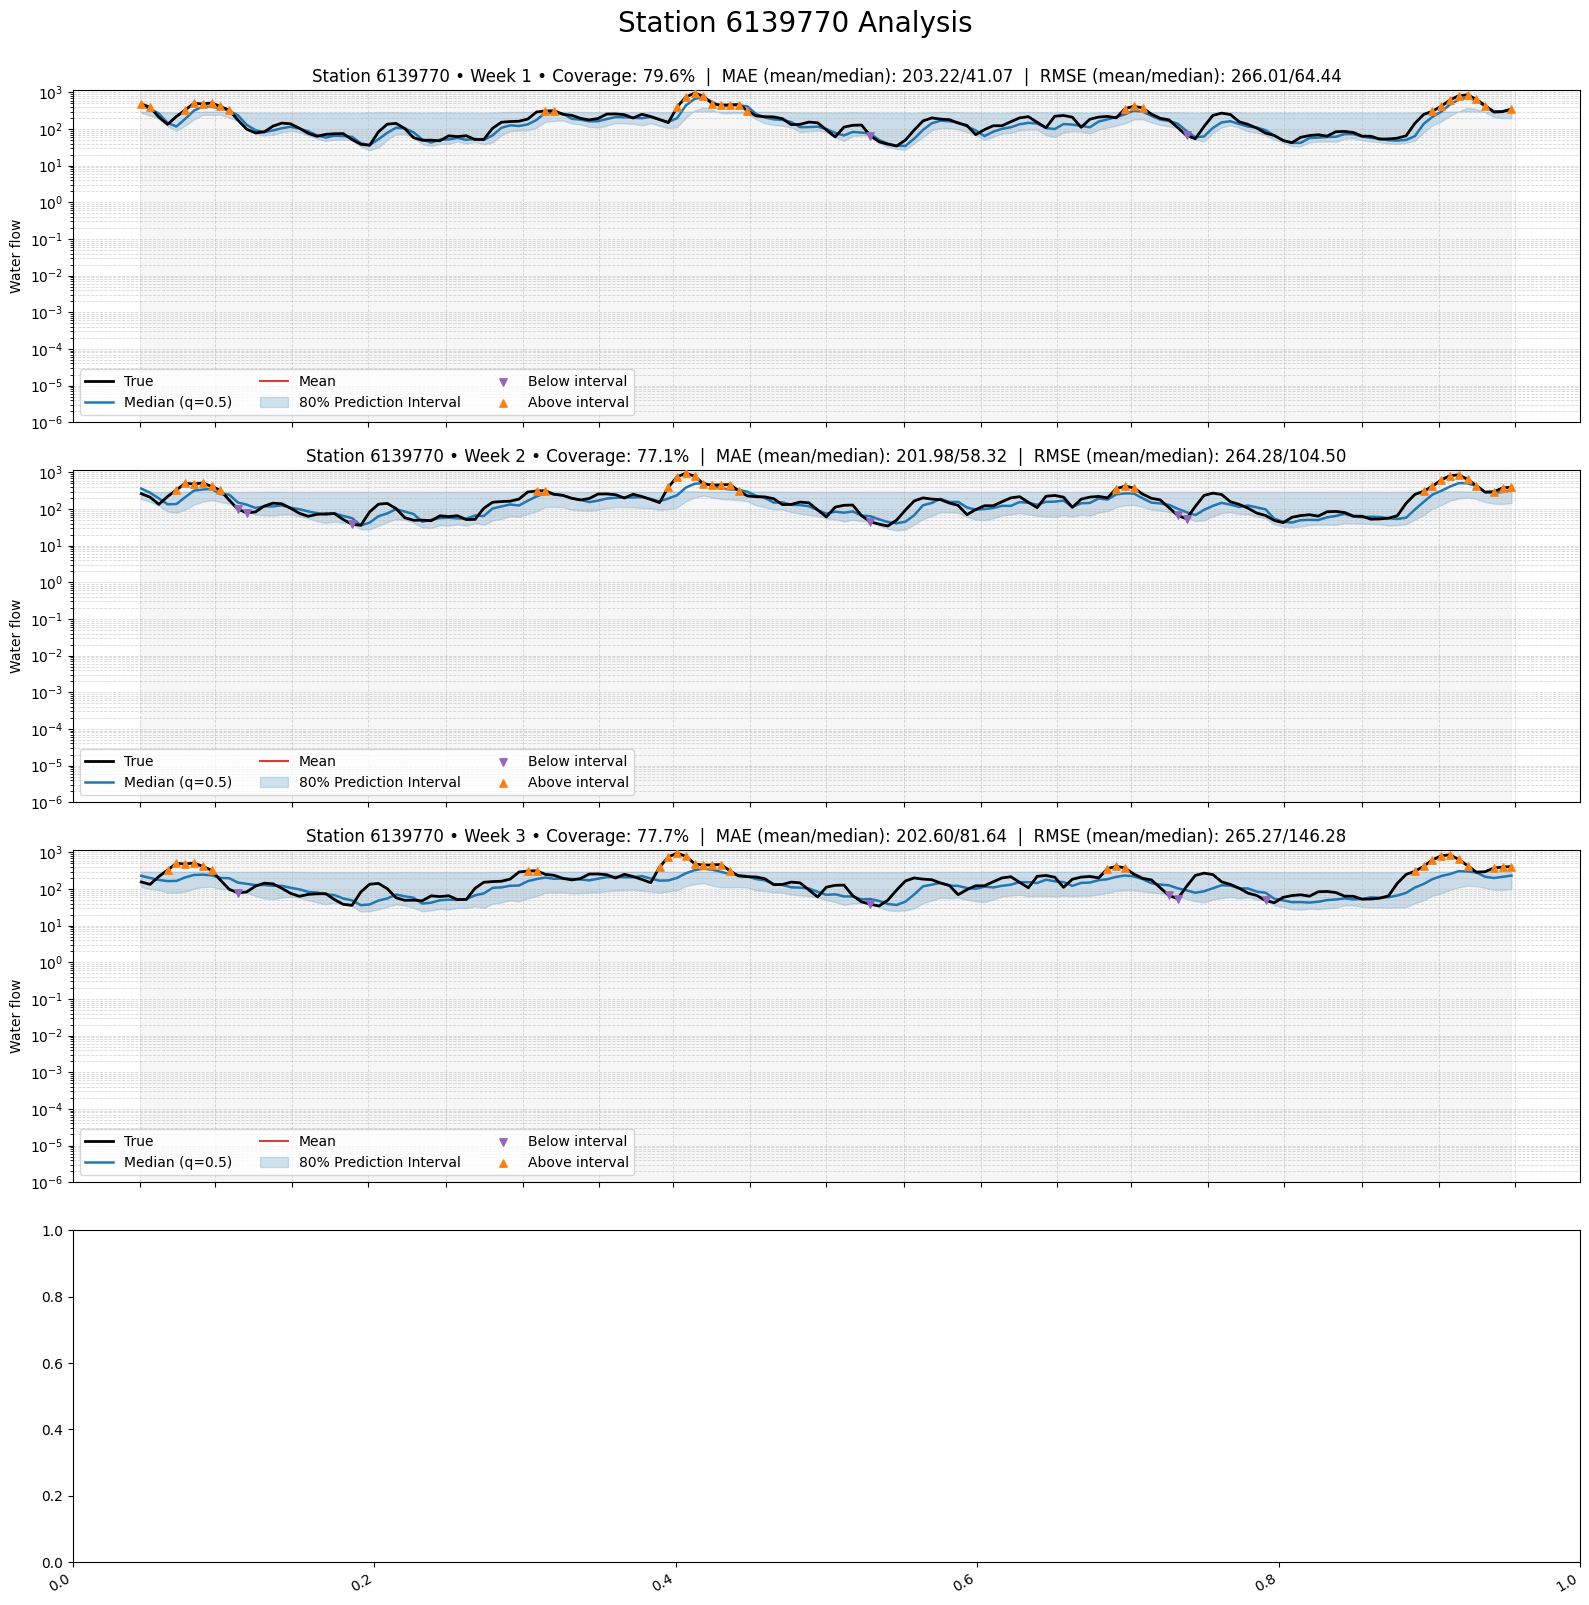

In [13]:
results_df_train_to_plot = results_df_train.copy()
# add column with regression with mock values
results_df_train_to_plot["water_flow_week1_LGBM_regression"] = 0
results_df_train_to_plot["water_flow_week2_LGBM_regression"] = 0
results_df_train_to_plot["water_flow_week3_LGBM_regression"] = 0
# result_df_train_to_plot["water_flow_week4_LGBM_regression"] = 0

station_ids = results_df_train["station_code"].unique()
station_id = np.random.choice(station_ids)

fig, axes = plt.subplots(len(TARGETS), 1, figsize=(16, 16))
plt.suptitle(f"Station {station_id} Analysis", fontsize=20, y=1.0)

for week_pred in range(len(TARGETS) - 1):
    plot_station_quantiles(
        axes[week_pred],
        results_df_train_to_plot,
        station_id,
        week_pred=week_pred + 1,
        q_lo=0.1,
        q_hi=0.9,
        use_logy=True,
        smooth_window=3,
    )

plt.tight_layout()
plt.show()

Save model and best params


In [14]:
# LOAD SAVED MODELS
with open(
    file_path,
    "rb",
) as f:
    all_models = pickle.load(f)

In [15]:
# sort test data by ObsDate and station_code
spatio_temporal_test = spatio_temporal_test.sort_values(
    by=["ObsDate", "station_code"]
).reset_index(drop=True)
temporal_test = temporal_test.sort_values(by=["ObsDate", "station_code"]).reset_index(
    drop=True
)

pred_spatio_temporal, full_pred_spatio_temporal = run_test_pipeline_extended(
    all_models, spatio_temporal_test
)
pred_temporal, full_pred_temporal = run_test_pipeline_extended(
    all_models, temporal_test
)

for i in range(NUMBER_OF_WEEK - 1):
    week = i + 1
    mse_spatio_temporal = mean_squared_error(
        spatio_temporal_test[f"water_flow_week{week}"],
        pred_spatio_temporal[f"week_{i}_pred"],
    )
    print(f"MSE Spatio-Temporal Test Week {week}: {mse_spatio_temporal}")

for i in range(NUMBER_OF_WEEK - 1):
    week = i + 1
    mse_temporal = mean_squared_error(
        temporal_test[f"water_flow_week{week}"],
        pred_temporal[f"week_{i}_pred"],
    )
    print(f"MSE Temporal Test Week {week}: {mse_temporal}")

MSE Spatio-Temporal Test Week 1: 48.99372844662944
MSE Spatio-Temporal Test Week 2: 185.18164346502576
MSE Temporal Test Week 1: 10992.360794862225
MSE Temporal Test Week 2: 18244.376546523425


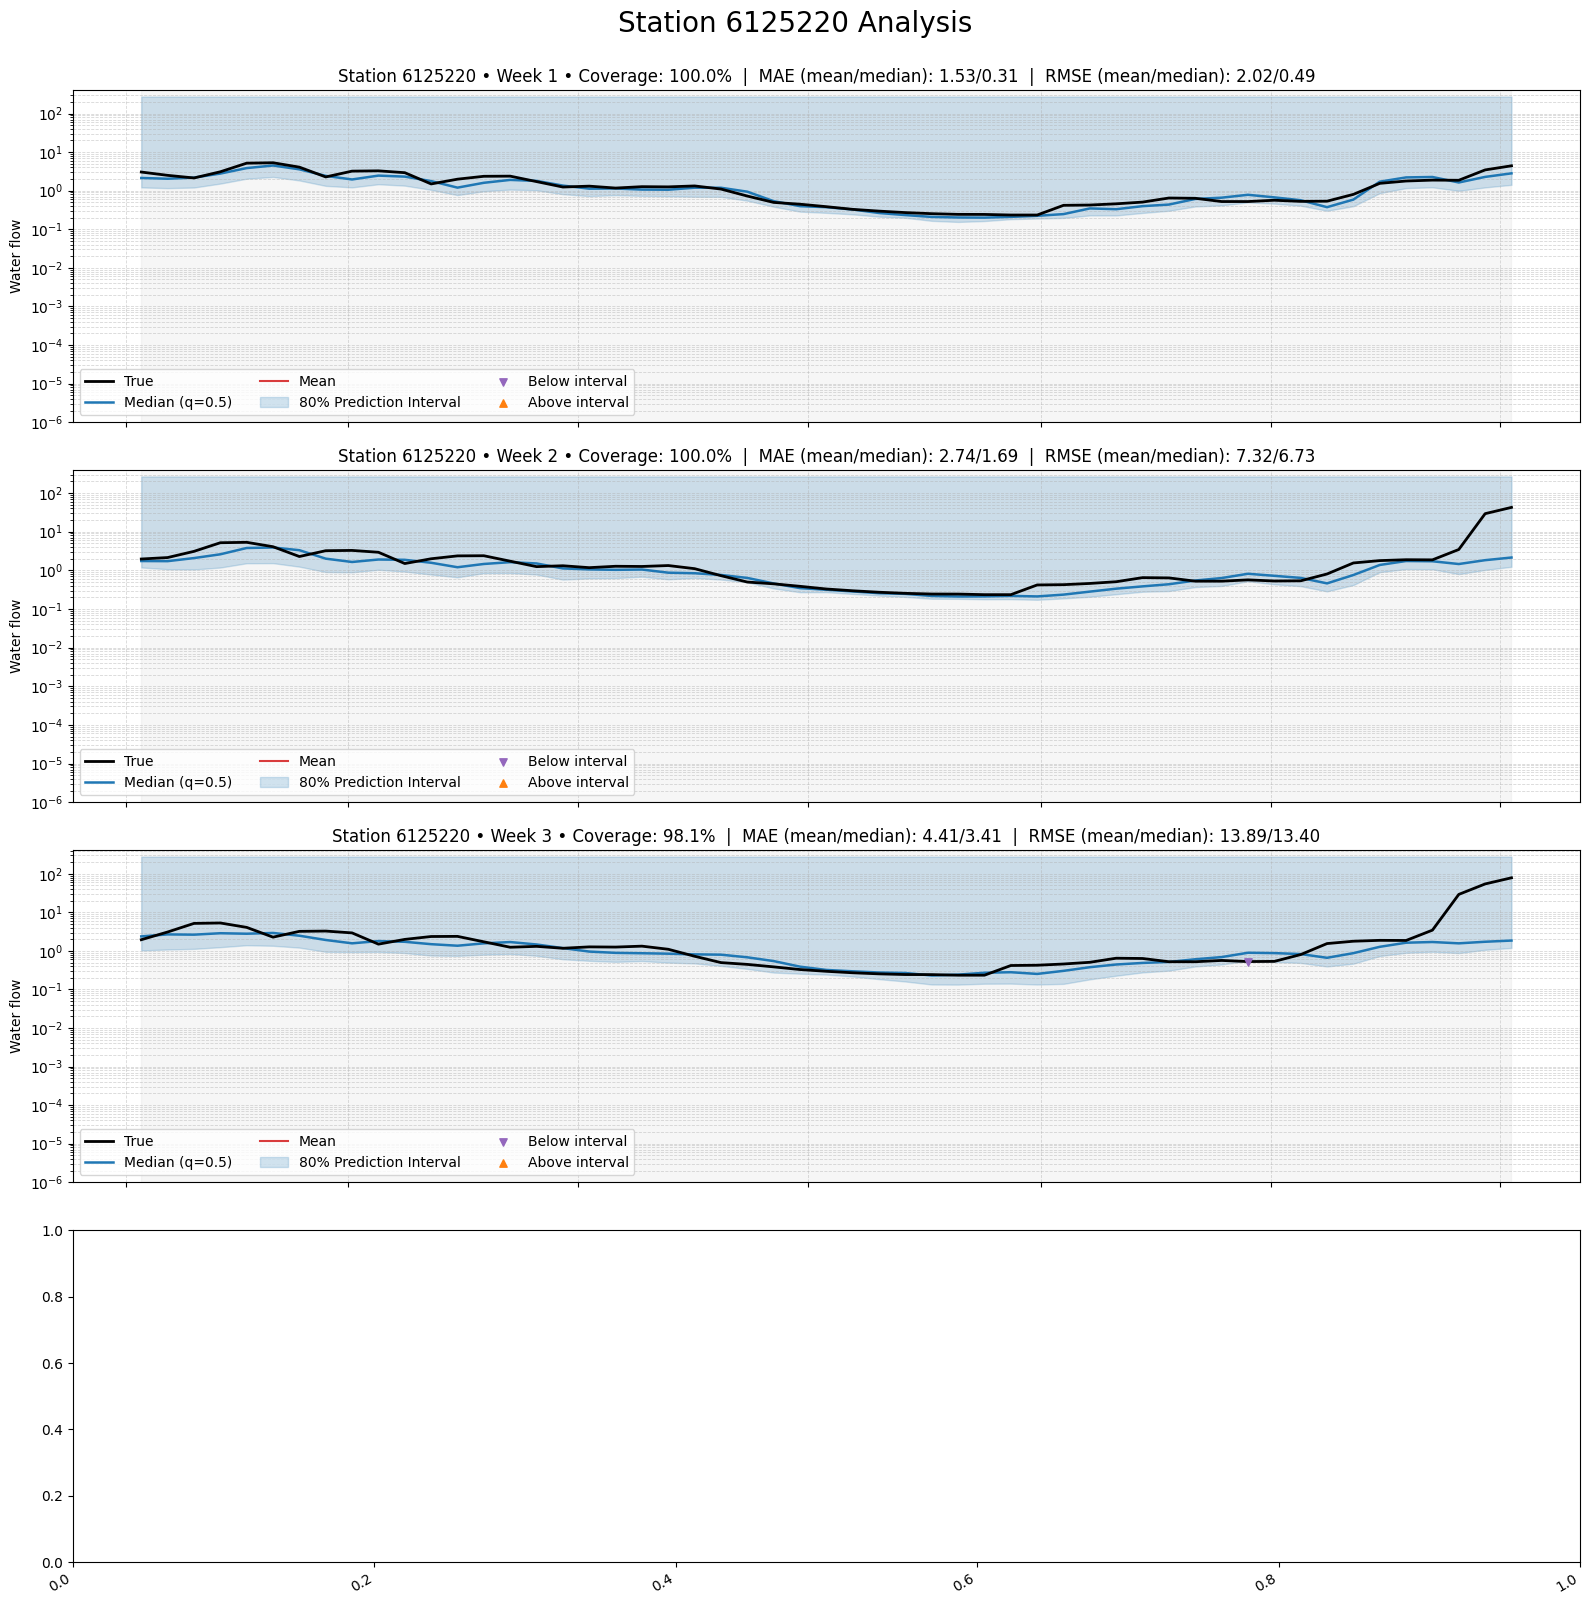

In [16]:
full_pred_spatio_temporal_to_plot = full_pred_spatio_temporal.copy()
# add column with regression with mock values
full_pred_spatio_temporal_to_plot["water_flow_week1_LGBM_regression"] = 0
full_pred_spatio_temporal_to_plot["water_flow_week2_LGBM_regression"] = 0
full_pred_spatio_temporal_to_plot["water_flow_week3_LGBM_regression"] = 0
# full_pred_spatio_temporal_to_plot["water_flow_week4_LGBM_regression"] = 0

station_ids = full_pred_spatio_temporal["station_code"].unique()
station_id = np.random.choice(station_ids)

fig, axes = plt.subplots(len(TARGETS), 1, figsize=(16, 16))
plt.suptitle(f"Station {station_id} Analysis", fontsize=20, y=1.0)

for week_pred in range(len(TARGETS) - 1):
    plot_station_quantiles(
        axes[week_pred],
        full_pred_spatio_temporal_to_plot,
        station_id,
        week_pred=week_pred + 1,
        q_lo=0.1,
        q_hi=0.9,
        use_logy=True,
        smooth_window=3,
    )

plt.tight_layout()
plt.show()

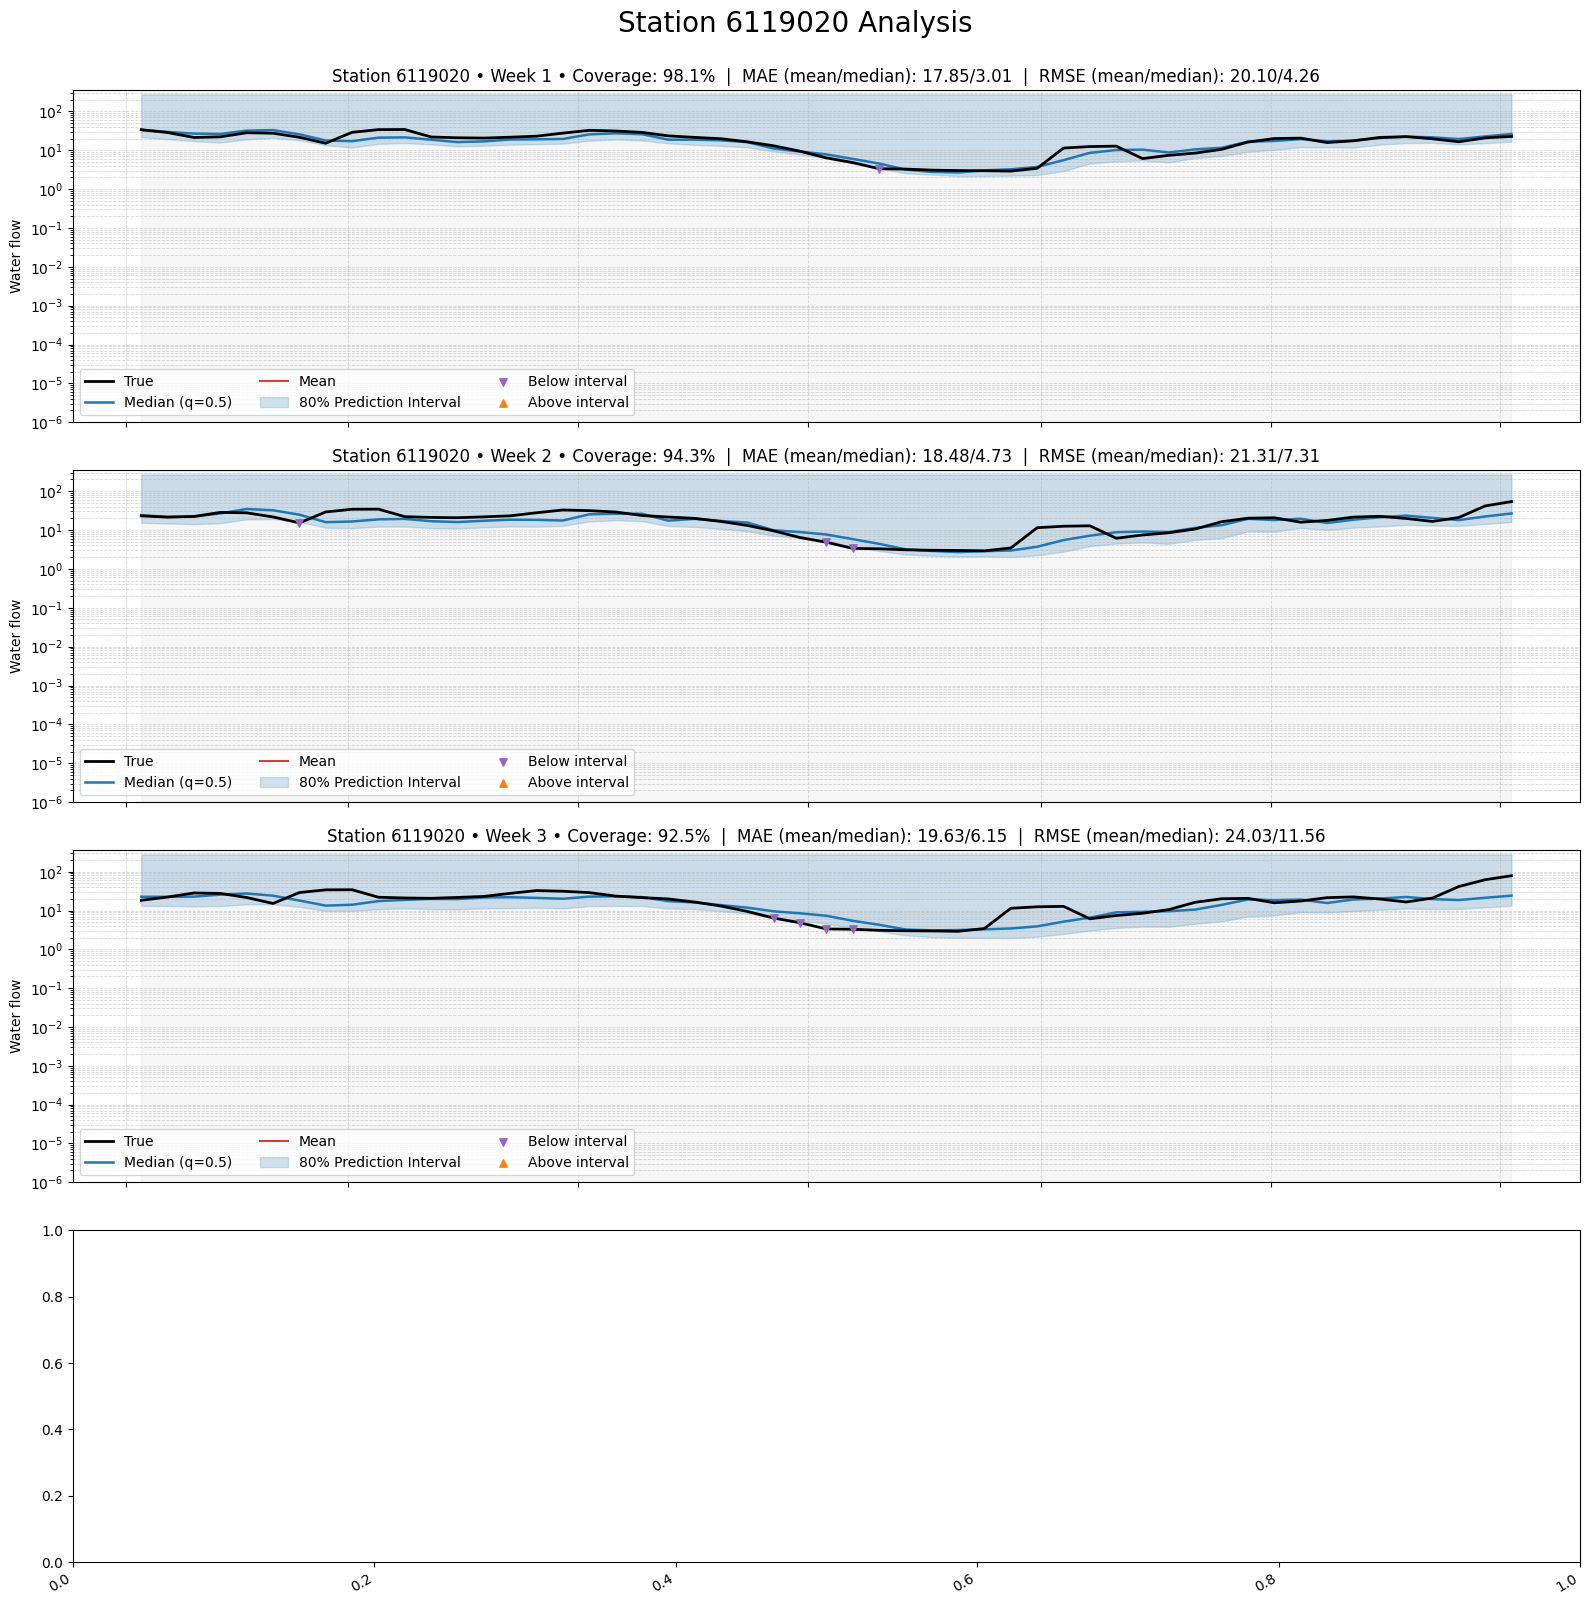

In [17]:
full_pred_temporal_to_plot = full_pred_temporal.copy()
# add column with regression with mock values
full_pred_temporal_to_plot["water_flow_week1_LGBM_regression"] = 0
full_pred_temporal_to_plot["water_flow_week2_LGBM_regression"] = 0
full_pred_temporal_to_plot["water_flow_week3_LGBM_regression"] = 0
# full_pred_temporal_to_plot["water_flow_week4_LGBM_regression"] = 0

station_ids = full_pred_temporal["station_code"].unique()
station_id = np.random.choice(station_ids)

fig, axes = plt.subplots(len(TARGETS), 1, figsize=(16, 16))
plt.suptitle(f"Station {station_id} Analysis", fontsize=20, y=1.0)

for week_pred in range(len(TARGETS) - 1):
    plot_station_quantiles(
        axes[week_pred],
        full_pred_temporal_to_plot,
        station_id,
        week_pred=week_pred + 1,
        q_lo=0.1,
        q_hi=0.9,
        use_logy=True,
        smooth_window=3,
    )

plt.tight_layout()
plt.show()

In [18]:
pred_spatio_temporal

,id,week_0_pred,week_1_pred,week_2_pred
0,6119040_2003-01-05,25.693982,20.813478,17.780491
1,6125220_2003-01-05,1.615774,1.568897,2.599640
2,6139520_2003-01-05,5.429958,4.889798,4.872522
3,6139560_2003-01-05,1.353264,1.538839,1.913385
4,6119040_2003-01-12,32.509584,18.855605,18.079387
...,...,...,...,...
207,6139560_2003-12-28,0.442315,0.402950,0.532941
208,6119040_2004-01-04,50.547591,43.956050,30.055281
209,6125220_2004-01-04,3.847538,2.733031,2.204691
210,6139520_2004-01-04,1.117751,1.514167,2.078338


### predictions on public test data


In [19]:
def train_final_models_no_validation(
    Xtr,
    ytr,
    best_params,
    target_name,
    quantiles=[0.1, 0.5, 0.9],
    if_regression=False,
    if_quantiles=True,
):
    """
    Instantiates models using provided best parameters and performs a final fit
    on the full training data (Xtr, ytr) without any validation set or early stopping.

    Args:
        Xtr (pd.DataFrame): Training features.
        ytr (pd.Series): Training target variable.
        best_params (dict): Dictionary of cleaned, optimized hyperparameters
                            for the LGBM model (e.g., {'num_leaves': 50, 'n_estimators': 850}).
        target_name (str): Name of the target variable for logging purposes.
        quantiles (list): List of quantile levels to train models for.
        if_regression (bool): Whether to train a standard regression model.
        if_quantiles (bool): Whether to train quantile regression models.

    Returns:
        dict: A dictionary containing the fitted model objects.
    """
    print(f"--- Training FINAL Models for: {target_name} ---")
    final_models = {}

    if if_quantiles:
        for q in quantiles:
            model_key = f"LGBM_quantile_{q}"
            print(f"Starting final fit for {model_key}...")

            # 1. Build quantile model using best_params
            model_q = build_quantile_lgbm(alpha=q, params=best_params)

            # 2. Wrap model for transformation
            model_q_wrapped = TransformedTargetRegressor(
                regressor=model_q,
                func=log_transform,
                inverse_func=inverse_log_transform,
            )

            # 3. Fit on full training data (no validation)
            model_q_wrapped.fit(Xtr, ytr)

            final_models[model_key] = model_q_wrapped

    if if_regression:
        model_key = "LGBM_regression"
        print(f"Starting final fit for {model_key}...")

        # 1. Build regression model using best_params
        model_reg = build_regression_lgbm(params=best_params)

        # 2. Wrap model for transformation
        model_reg_wrapped = TransformedTargetRegressor(
            regressor=model_reg,
            func=log_transform,
            inverse_func=inverse_log_transform,
        )

        # 3. Fit on full training data (no validation)
        model_reg_wrapped.fit(Xtr, ytr)

        final_models[model_key] = model_reg_wrapped

    print(f"--- Final Models for {target_name} Trained ---")
    return {"models": final_models}


def train_final_models_all_targets(
    Xtr, ytr_all, best_params_all, quantiles=[0.1, 0.5, 0.9]
):
    """
    Loops through all targets and trains final models on the full training data.

    Args:
        Xtr (pd.DataFrame): Training features.
        ytr_all (pd.DataFrame): DataFrame containing all target variables.
        best_params_all (dict): Dictionary mapping each target to its best hyperparameters.
        quantiles (list): List of quantile levels to train models for.
    Returns:
        dict: A dictionary containing all trained models for each target.
    """
    results = {}

    for i, target in enumerate(TARGETS):
        print(f"\n=== Training FINAL models for {target} ===")
        ytr = ytr_all[target]

        best_params = best_params_all.get(target, {})

        target_results = train_final_models_no_validation(
            Xtr,
            ytr,
            best_params=best_params,
            target_name=target,
            quantiles=quantiles,
            if_regression=False,
            if_quantiles=True,
        )

        # 3. Store results
        results[target] = {
            **target_results,  # Unpack models, preds, carbon_results
            "true": ytr.values,
        }

    print("\n=== FINAL Training complete ===")
    return results

In [20]:
# def create_model_from_params(best_params):
#     model = LGBMRegressor(**best_params)
#     wrapped_model = TransformedTargetRegressor(
#         regressor=model,
#         func=log_transform,
#         inverse_func=inverse_log_transform,
#     )
#     return wrapped_model


# test_model = create_model_from_params(all_best_params)
# final_results

In [22]:
# save the predictions to a csv file
predictions, full_pred_test = run_test_pipeline_extended(all_models, dataset_test)
# predictions.drop(columns=["week_3_pred"], inplace=True)
predictions.to_csv(
    f"../../preds/predictions_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv",
    index=False,
)
predictions

,id,week_0_pred,week_1_pred,week_2_pred
0,6119020_2004-02-01,41.492067,26.052688,33.798046
1,6119030_2004-02-01,107.525385,66.416594,74.066961
2,6119040_2004-02-01,50.222789,29.179220,37.952942
3,6119110_2004-02-01,4.939147,4.135288,6.861726
4,6119120_2004-02-01,14.191300,9.100262,11.353807
...,...,...,...,...
1347,56960005_2009-11-01,41.691885,48.219529,54.653800
1348,56976000_2009-11-01,106.532169,112.145101,140.018771
1349,56978000_2009-11-01,108.188165,111.812808,152.627311
1350,56990000_2009-11-01,211.751104,462.245596,400.696438


In [ ]:
import os

print(os.getcwd())

/Users/julesroyer/Code/IDSC-CODE/data-challenge-capgemini/data_challenge_mines2025/src2/notebooks


In [ ]:
# feature importance
model_to_inspect = all_models[f"week_1"]["LGBM_quantile_0.5"]
importances = model_to_inspect.regressor_.feature_importances_
feature_names = model_to_inspect.regressor_.feature_name_
feature_importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": importances}
).sort_values(by="importance", ascending=False)
feature_importance_df.head(20)

# analyze number of training steps
model_to_inspect.regressor_.best_iteration_

606